In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf

# Data cleaning and normalization

In [2]:
training_session_folder = 'C:/Users/chiny/cjwen/ITI110/hourly_training'
df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")


In [3]:
df.isnull().sum()      

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

In [4]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])
# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]

,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


In [5]:
df = df.drop([15758, 15759])

In [6]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())


# Create X new columns using past X timestamp data

In [7]:
dataframe = df.loc[:,"avg_energy_per_lclid"]
dataset = dataframe.values
dataset = dataset.astype("float32")

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
history = 24
future = 24
reframed = series_to_supervised(dataset, history,future)
reframed.head(3)



,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
24,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,...,0.47856,0.47504,0.50696,0.49580,0.43692,0.33592,0.27364,0.29892,0.331920,0.369720
25,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,...,0.47504,0.50696,0.49580,0.43692,0.33592,0.27364,0.29892,0.33192,0.369720,0.363615
26,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,...,0.50696,0.49580,0.43692,0.33592,0.27364,0.29892,0.33192,0.36972,0.363615,0.334107


In [10]:
scaler_label = MinMaxScaler(feature_range=(0, 1))

In [11]:
# Merge the reframed columns with weather and time features

In [12]:
reframed

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
24,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,...,0.478560,0.475040,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720
25,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,...,0.475040,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615
26,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,...,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107
27,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,...,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107,0.354800
28,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,0.602615,...,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107,0.354800,0.344719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19834,0.652895,0.580244,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,...,0.395175,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360
19835,0.580244,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,...,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011
19836,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,0.466477,...,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121
19837,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,0.466477,0.431787,...,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473


In [13]:
len(df.month.values[history:-history+1])

19815

In [14]:
reframed["month"] = df.month.values[history:-history+1]
reframed["hour"] = df.hour.values[history:-history+1]
reframed["temperature"] = df.temperature.values[history:-history+1]
reframed["humidity"] = df.humidity.values[history:-history+1]
reframed["windSpeed"] = df.windSpeed.values[history:-history+1]
reframed["holiday"] = df.holiday.values[history:-history+1]

In [15]:
reframed_tstp = pd.DataFrame()
reframed_tstp["tstp"] = df.tstp.values[history:-history+1]

In [16]:
reframed_tstp

,tstp
0,2011-11-24 09:00:00
1,2011-11-24 10:00:00
2,2011-11-24 11:00:00
3,2011-11-24 12:00:00
4,2011-11-24 13:00:00
...,...
19810,2014-02-26 21:00:00
19811,2014-02-26 22:00:00
19812,2014-02-26 23:00:00
19813,2014-02-27 00:00:00


In [17]:
reframed

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t+20),var1(t+21),var1(t+22),var1(t+23),month,hour,temperature,humidity,windSpeed,holiday
24,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,...,0.273640,0.298920,0.331920,0.369720,11,9,10.12,0.95,3.36,0.0
25,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,...,0.298920,0.331920,0.369720,0.363615,11,10,10.99,0.93,3.59,0.0
26,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,...,0.331920,0.369720,0.363615,0.334107,11,11,12.29,0.88,4.35,0.0
27,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,...,0.369720,0.363615,0.334107,0.354800,11,12,12.93,0.81,5.26,0.0
28,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,0.665231,0.602615,...,0.363615,0.334107,0.354800,0.344719,11,13,12.92,0.78,5.66,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19834,0.652895,0.580244,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,...,0.507056,0.658782,0.722878,0.694360,2,21,6.58,0.77,3.97,0.0
19835,0.580244,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,...,0.658782,0.722878,0.694360,0.657011,2,22,6.24,0.80,3.74,0.0
19836,0.458920,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,0.466477,...,0.722878,0.694360,0.657011,0.587121,2,23,6.27,0.81,3.69,0.0
19837,0.384413,0.305555,0.258451,0.236224,0.228710,0.243217,0.303376,0.420065,0.466477,0.431787,...,0.694360,0.657011,0.587121,0.469473,2,0,6.01,0.82,4.13,0.0


In [18]:
reframed.columns

Index(['var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)', 'var1(t+15)',
       'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)', 'var1(t+20)',
       'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'month', 'hour',
       'temperature', 'humidity', 'windSpeed', 'holiday'],
      dtype='object')

In [19]:
reframed = reframed.reindex(["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)', 'var1(t+15)',
       'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)', 'var1(t+20)',
       'var1(t+21)', 'var1(t+22)', 'var1(t+23)'],axis=1)

In [20]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19815 entries, 24 to 19838
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        19815 non-null  int64  
 1   hour         19815 non-null  int64  
 2   temperature  19815 non-null  float64
 3   humidity     19815 non-null  float64
 4   windSpeed    19815 non-null  float64
 5   holiday      19815 non-null  float64
 6   var1(t-24)   19815 non-null  float32
 7   var1(t-23)   19815 non-null  float32
 8   var1(t-22)   19815 non-null  float32
 9   var1(t-21)   19815 non-null  float32
 10  var1(t-20)   19815 non-null  float32
 11  var1(t-19)   19815 non-null  float32
 12  var1(t-18)   19815 non-null  float32
 13  var1(t-17)   19815 non-null  float32
 14  var1(t-16)   19815 non-null  float32
 15  var1(t-15)   19815 non-null  float32
 16  var1(t-14)   19815 non-null  float32
 17  var1(t-13)   19815 non-null  float32
 18  var1(t-12)   19815 non-null  float32
 19  var1(t-1

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))

reframed[["month","hour","temperature","humidity","windSpeed","holiday"]] = scaler.fit_transform(reframed[["month","hour","temperature","humidity","windSpeed","holiday"]])

In [69]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

In [70]:
# weather_cluster = reframed[["temperature","month",'humidity','windSpeed']]

In [71]:
# Nc = range(1,20)
# kmeans = [KMeans(n_clusters=i) for i in Nc]

# score = [kmeans[i].fit(weather_cluster).score(weather_cluster) for i in range(len(kmeans))]
# score
# plt.plot(Nc,score)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.title('Elbow Curve')
# plt.show()

In [72]:
# wcss = []
# for i in range(1, 11):  # Test 1 to 10 clusters
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(weather_cluster)
#     wcss.append(kmeans.inertia_)

# # Plot the Elbow graph
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

In [73]:
# silhouette_scores = []
# for i in range(2, 11):  # Silhouette score is not defined for a single cluster
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(weather_cluster)
#     cluster_labels = kmeans.labels_
#     silhouette_scores.append(silhouette_score(weather_cluster, cluster_labels))

# # Plot the Silhouette scores
# plt.plot(range(2, 11), silhouette_scores)
# plt.title('Silhouette Score Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Silhouette Score')
# plt.show()

# Split data

In [23]:
train_rows = int(0.8*len(reframed))
train = reframed[:train_rows]
test = reframed[train_rows:]

print("dataset no. of rows: ", len(reframed))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

dataset no. of rows:  19815
train dataset no. of rows:  15852
test dataset no. of rows:  3963


In [24]:
train_tstp = reframed_tstp[:train_rows]
test_tstp = reframed_tstp[train_rows:]

print("dataset no. of rows: ", len(reframed_tstp))
print("train_tstp dataset no. of rows: ", len(train_tstp))
print("test_tstp dataset no. of rows: ", len(test_tstp))

dataset no. of rows:  19815
train_tstp dataset no. of rows:  15852
test_tstp dataset no. of rows:  3963


In [25]:
test.tail()

,month,hour,temperature,humidity,windSpeed,holiday,var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
19834,0.090909,0.913043,0.321241,0.701299,0.266260,0.0,0.652895,0.580244,0.458920,0.384413,...,0.395175,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360
19835,0.090909,0.956522,0.312303,0.740260,0.250678,0.0,0.580244,0.458920,0.384413,0.305555,...,0.392714,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011
19836,0.090909,1.000000,0.313091,0.753247,0.247290,0.0,0.458920,0.384413,0.305555,0.258451,...,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121
19837,0.090909,0.000000,0.306257,0.766234,0.277100,0.0,0.384413,0.305555,0.258451,0.236224,...,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473
19838,0.090909,0.043478,0.320189,0.740260,0.337398,0.0,0.305555,0.258451,0.236224,0.228710,...,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473,0.209844


In [26]:
features = ["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)', 'var1(t-20)',
       'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)', 'var1(t-15)',
       'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']
label = ['var1(t)',
       'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)', 'var1(t+15)',
       'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)', 'var1(t+20)',
       'var1(t+21)', 'var1(t+22)', 'var1(t+23)']

In [27]:
train_X = np.array(train[features])
train_y = np.array(train[label])
test_X = np.array(test[features])
test_y = np.array(test[label])

In [28]:
# train_X_norm = scaler_features.fit_transform(train_X)
# test_X_norm = scaler_features.fit_transform(test_X)
# train_y_norm = scaler_label.fit_transform(train_y)
# test_y_norm = scaler_label.fit_transform(test_y)


In [29]:
train_X.shape

(15852, 30)

In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(15852, 1, 30) (15852, 24) (3963, 1, 30) (3963, 24)


In [31]:
def performance_visualization(model, train_input, train_actual, test_input, test_actual, start_row=0, end_row=100):
    train_result = pd.DataFrame()
    train_pred = model.predict(train_input)
    train_mae = mae(train_actual, train_pred)
    train_mape = mape(train_actual,train_pred)
    train_rmse = math.sqrt(mean_squared_error(train_actual,train_pred))
    train_result["tstp"] = train_tstp["tstp"]
    train_result["tstp"] = pd.to_datetime(train_result["tstp"])
    train_result["train_pred"]= train_pred
    train_result["train_actual"]= train_actual
    print(f"Train MAE: {train_mae}")
    print(f"Train MAPE: {train_mape}")
    print(f"Train RMSE: {train_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "train_actual", label='actual', data = train_result[start_row:end_row])
    plt.plot("tstp", "train_pred", label='prediction', data = train_result[start_row:end_row])

    # plt.plot(train_pred[start_row:end_row], label='prediction', x = "tstp")
    plt.title("Train Actual vs prediction")
    plt.legend()
    plt.show()
              
              
    test_result = pd.DataFrame()
    test_pred = model.predict(test_input)
    test_mae = mae(test_actual, test_pred)
    test_mape = mape(test_actual,test_pred)
    test_rmse = math.sqrt(mean_squared_error(test_actual,test_pred))
    test_result["tstp"] = test_tstp["tstp"]
    test_result["tstp"] = pd.to_datetime(test_result["tstp"])
    test_result["test_pred"]= test_pred
    test_result["test_actual"]= test_actual
    print(f"Test MAE: {test_mae}")
    print(f"Test MAPE: {test_mape}")
    print(f"Test RMSE: {test_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "test_actual", label='actual', data = test_result[start_row:end_row])
    plt.plot("tstp", "test_pred", label='prediction', data = test_result[start_row:end_row])
    plt.title("Test Actual vs prediction")
    plt.legend()
    plt.show()          
    
    return train_result, test_result

# Run 14 - 2 layers LSTM 96 neurons

In [32]:
model14 = Sequential()
    
model14.add(LSTM(units = 96, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model14.add(LSTM(units = 96))
model14.add(Dense(future))
    
model14.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanAbsoluteError()])

In [33]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_14/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

Epoch 1/500

496/496 [==============================] - 4s 3ms/step - loss: 0.0687 - mean_absolute_error: 0.0687 - val_loss: 0.0326 - val_mean_absolute_error: 0.0326
Epoch 2/500
496/496 [==============================] - 1s 2ms/step - loss: 0.0310 - mean_absolute_error: 0.0310 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 3/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0290 - mean_absolute_error: 0.0290 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 4/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280
Epoch 5/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - val_loss: 0.0264 - val_mean_absolute_error: 0.0264
Epoch 6/500
496/496 [==============================] - 1s 3ms/step - loss: 0.0262 - mean_absolute_error: 0.0262 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 7/5

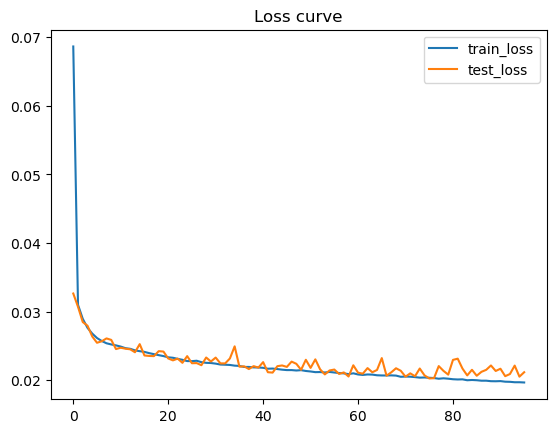

In [34]:
history = model14.fit(train_X, train_y, epochs=500, validation_data = (test_X, test_y), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

In [35]:
# train_result, test_result = performance_visualization(model12, train_X, train_y, test_X, test_y, 1900, 2000)

In [36]:
train_result= pd.DataFrame()
train_result[['var1(t)_pred',
       'var1(t+1)_pred', 'var1(t+2)_pred', 'var1(t+3)_pred', 'var1(t+4)_pred', 'var1(t+5)_pred',
       'var1(t+6)_pred', 'var1(t+7)_pred', 'var1(t+8)_pred', 'var1(t+9)_pred', 'var1(t+10)_pred',
       'var1(t+11)_pred', 'var1(t+12)_pred', 'var1(t+13)_pred', 'var1(t+14)_pred', 'var1(t+15)_pred',
       'var1(t+16)_pred', 'var1(t+17)_pred', 'var1(t+18)_pred', 'var1(t+19)_pred', 'var1(t+20)_pred',
       'var1(t+21)_pred', 'var1(t+22)_pred', 'var1(t+23)_pred']] = model14.predict(train_X)

496/496 [==============================] - 1s 941us/step


In [37]:
train_result[['var1(t)',
       'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)', 'var1(t+15)',
       'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)', 'var1(t+20)',
       'var1(t+21)', 'var1(t+22)', 'var1(t+23)']]= train_y

In [38]:
train_result

,var1(t)_pred,var1(t+1)_pred,var1(t+2)_pred,var1(t+3)_pred,var1(t+4)_pred,var1(t+5)_pred,var1(t+6)_pred,var1(t+7)_pred,var1(t+8)_pred,var1(t+9)_pred,...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,0.407157,0.408622,0.432006,0.584043,0.559585,0.492376,0.481955,0.504557,0.517076,0.651121,...,0.478560,0.475040,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720
1,0.355306,0.413631,0.491016,0.473412,0.459597,0.452406,0.439253,0.504001,0.616497,0.772008,...,0.475040,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615
2,0.450338,0.551677,0.552560,0.517952,0.521093,0.510128,0.527607,0.641159,0.785278,0.785760,...,0.506960,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107
3,0.452382,0.442637,0.427320,0.480599,0.506955,0.538843,0.647942,0.782263,0.764038,0.674302,...,0.495800,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107,0.354800
4,0.419818,0.424956,0.441091,0.462494,0.507728,0.607078,0.781403,0.809118,0.691702,0.597839,...,0.436920,0.335920,0.273640,0.298920,0.331920,0.369720,0.363615,0.334107,0.354800,0.344719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15847,0.572744,0.584735,0.550100,0.503090,0.414000,0.330866,0.274392,0.238809,0.210148,0.201891,...,0.406814,0.439729,0.436455,0.457963,0.500592,0.491061,0.486360,0.501016,0.553846,0.612852
15848,0.579845,0.548715,0.493943,0.414035,0.319189,0.270294,0.236514,0.213873,0.199556,0.204286,...,0.439729,0.436455,0.457963,0.500592,0.491061,0.486360,0.501016,0.553846,0.612852,0.638168
15849,0.564941,0.498868,0.411929,0.316566,0.262118,0.233375,0.210825,0.203161,0.201073,0.233777,...,0.436455,0.457963,0.500592,0.491061,0.486360,0.501016,0.553846,0.612852,0.638168,0.641594
15850,0.499614,0.411569,0.323104,0.264301,0.226617,0.207795,0.198084,0.201837,0.224206,0.291225,...,0.457963,0.500592,0.491061,0.486360,0.501016,0.553846,0.612852,0.638168,0.641594,0.588286


In [39]:
train_mae = {}

In [40]:
error=mae(train_result["var1(t)"],train_result["var1(t)_pred"])
error1=mae(train_result["var1(t+1)"],train_result["var1(t+1)_pred"])
error2=mae(train_result["var1(t+2)"],train_result["var1(t+2)_pred"])
error3=mae(train_result["var1(t+3)"],train_result["var1(t+3)_pred"])
error4=mae(train_result["var1(t+4)"],train_result["var1(t+4)_pred"])
error5=mae(train_result["var1(t+5)"],train_result["var1(t+5)_pred"])
error6=mae(train_result["var1(t+6)"],train_result["var1(t+6)_pred"])
error7=mae(train_result["var1(t+7)"],train_result["var1(t+7)_pred"])
error8=mae(train_result["var1(t+8)"],train_result["var1(t+8)_pred"])
error9=mae(train_result["var1(t+9)"],train_result["var1(t+9)_pred"])
error10=mae(train_result["var1(t+10)"],train_result["var1(t+10)_pred"])
error11=mae(train_result["var1(t+11)"],train_result["var1(t+11)_pred"])
error12=mae(train_result["var1(t+12)"],train_result["var1(t+12)_pred"])
error13=mae(train_result["var1(t+13)"],train_result["var1(t+13)_pred"])
error14=mae(train_result["var1(t+14)"],train_result["var1(t+14)_pred"])
error15=mae(train_result["var1(t+15)"],train_result["var1(t+15)_pred"])
error16=mae(train_result["var1(t+16)"],train_result["var1(t+16)_pred"])
error17=mae(train_result["var1(t+17)"],train_result["var1(t+17)_pred"])
error18=mae(train_result["var1(t+18)"],train_result["var1(t+18)_pred"])
error19=mae(train_result["var1(t+19)"],train_result["var1(t+19)_pred"])
error20=mae(train_result["var1(t+20)"],train_result["var1(t+20)_pred"])
error21=mae(train_result["var1(t+21)"],train_result["var1(t+21)_pred"])
error22=mae(train_result["var1(t+22)"],train_result["var1(t+22)_pred"])
error23=mae(train_result["var1(t+23)"],train_result["var1(t+23)_pred"])

In [41]:
train_mae["var1(t)"]=error
train_mae["var1(t+1)"]=error1
train_mae["var1(t+2)"]=error2
train_mae["var1(t+3)"]=error3
train_mae["var1(t+4)"]=error4
train_mae["var1(t+5)"]=error5
train_mae["var1(t+6)"]=error6
train_mae["var1(t+7)"]=error7
train_mae["var1(t+9)"]=error9
train_mae["var1(t+10)"]=error10
train_mae["var1(t+11)"]=error11
train_mae["var1(t+12)"]=error12
train_mae["var1(t+13)"]=error13
train_mae["var1(t+14)"]=error14
train_mae["var1(t+15)"]=error15
train_mae["var1(t+16)"]=error16
train_mae["var1(t+17)"]=error17
train_mae["var1(t+18)"]=error18
train_mae["var1(t+19)"]=error19
train_mae["var1(t+20)"]=error20
train_mae["var1(t+21)"]=error21
train_mae["var1(t+22)"]=error22
train_mae["var1(t+23)"]=error23

In [44]:
train_mape = {}

error=mape(train_result["var1(t)"],train_result["var1(t)_pred"])
error1=mape(train_result["var1(t+1)"],train_result["var1(t+1)_pred"])
error2=mape(train_result["var1(t+2)"],train_result["var1(t+2)_pred"])
error3=mape(train_result["var1(t+3)"],train_result["var1(t+3)_pred"])
error4=mape(train_result["var1(t+4)"],train_result["var1(t+4)_pred"])
error5=mape(train_result["var1(t+5)"],train_result["var1(t+5)_pred"])
error6=mape(train_result["var1(t+6)"],train_result["var1(t+6)_pred"])
error7=mape(train_result["var1(t+7)"],train_result["var1(t+7)_pred"])
error8=mape(train_result["var1(t+8)"],train_result["var1(t+8)_pred"])
error9=mape(train_result["var1(t+9)"],train_result["var1(t+9)_pred"])
error10=mape(train_result["var1(t+10)"],train_result["var1(t+10)_pred"])
error11=mape(train_result["var1(t+11)"],train_result["var1(t+11)_pred"])
error12=mape(train_result["var1(t+12)"],train_result["var1(t+12)_pred"])
error13=mape(train_result["var1(t+13)"],train_result["var1(t+13)_pred"])
error14=mape(train_result["var1(t+14)"],train_result["var1(t+14)_pred"])
error15=mape(train_result["var1(t+15)"],train_result["var1(t+15)_pred"])
error16=mape(train_result["var1(t+16)"],train_result["var1(t+16)_pred"])
error17=mape(train_result["var1(t+17)"],train_result["var1(t+17)_pred"])
error18=mape(train_result["var1(t+18)"],train_result["var1(t+18)_pred"])
error19=mape(train_result["var1(t+19)"],train_result["var1(t+19)_pred"])
error20=mape(train_result["var1(t+20)"],train_result["var1(t+20)_pred"])
error21=mape(train_result["var1(t+21)"],train_result["var1(t+21)_pred"])
error22=mape(train_result["var1(t+22)"],train_result["var1(t+22)_pred"])
error23=mape(train_result["var1(t+23)"],train_result["var1(t+23)_pred"])

train_mape["var1(t)"]=error
train_mape["var1(t+1)"]=error1
train_mape["var1(t+2)"]=error2
train_mape["var1(t+3)"]=error3
train_mape["var1(t+4)"]=error4
train_mape["var1(t+5)"]=error5
train_mape["var1(t+6)"]=error6
train_mape["var1(t+7)"]=error7
train_mape["var1(t+9)"]=error9
train_mape["var1(t+10)"]=error10
train_mape["var1(t+11)"]=error11
train_mape["var1(t+12)"]=error12
train_mape["var1(t+13)"]=error13
train_mape["var1(t+14)"]=error14
train_mape["var1(t+15)"]=error15
train_mape["var1(t+16)"]=error16
train_mape["var1(t+17)"]=error17
train_mape["var1(t+18)"]=error18
train_mape["var1(t+19)"]=error19
train_mape["var1(t+20)"]=error20
train_mape["var1(t+21)"]=error21
train_mape["var1(t+22)"]=error22
train_mape["var1(t+23)"]=error23

In [46]:
train_metric = [train_mae, train_mape]
train_metric_df = pd.DataFrame(train_metric, index=["train_mae","train_mape"]).transpose()

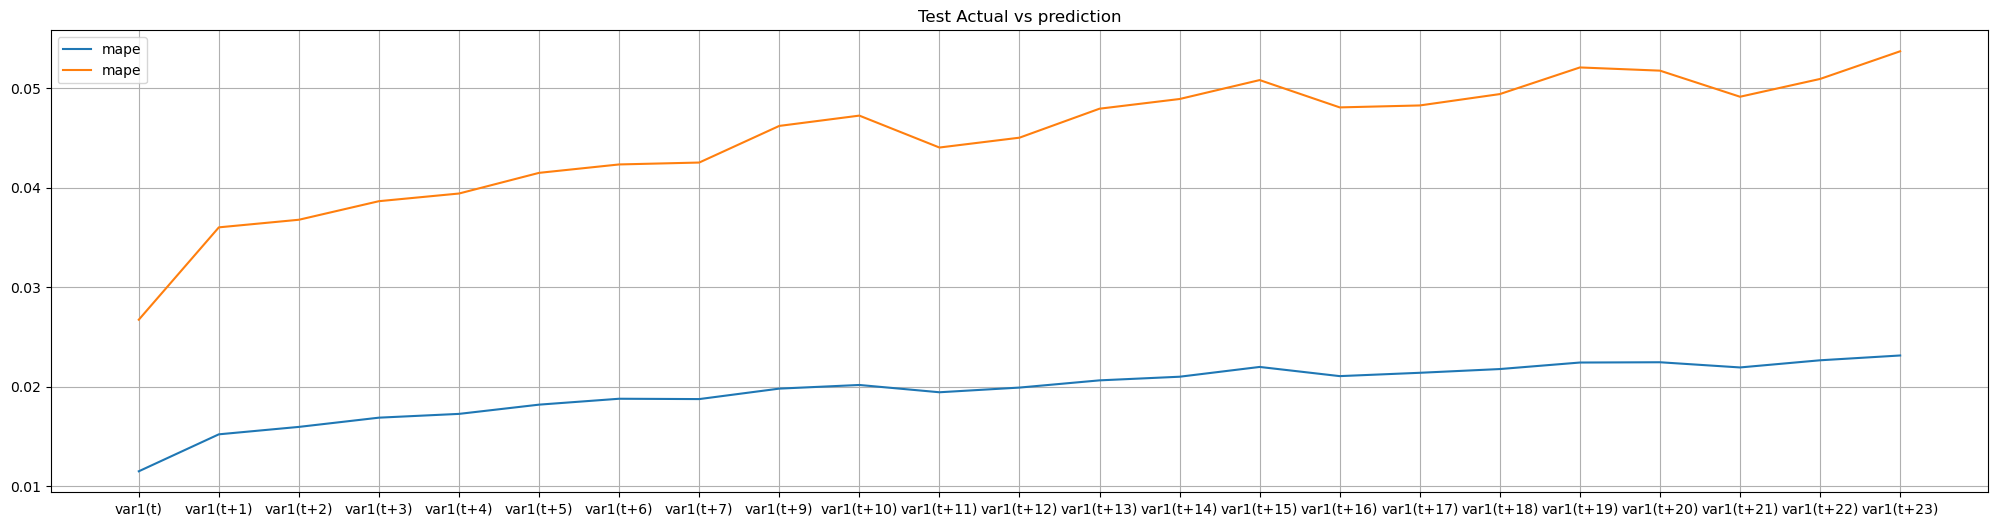

In [47]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot(train_metric_df.index, "train_mae", label='mape', data = train_metric_df)
plt.plot(train_metric_df.index, "train_mape", label='mape', data = train_metric_df)
plt.title("Test Actual vs prediction")
plt.legend()
plt.grid(True)
plt.show()         

# Compute Test prediction result

In [48]:
test_result= pd.DataFrame()
test_result[['var1(t)_pred',
       'var1(t+1)_pred', 'var1(t+2)_pred', 'var1(t+3)_pred', 'var1(t+4)_pred', 'var1(t+5)_pred',
       'var1(t+6)_pred', 'var1(t+7)_pred', 'var1(t+8)_pred', 'var1(t+9)_pred', 'var1(t+10)_pred',
       'var1(t+11)_pred', 'var1(t+12)_pred', 'var1(t+13)_pred', 'var1(t+14)_pred', 'var1(t+15)_pred',
       'var1(t+16)_pred', 'var1(t+17)_pred', 'var1(t+18)_pred', 'var1(t+19)_pred', 'var1(t+20)_pred',
       'var1(t+21)_pred', 'var1(t+22)_pred', 'var1(t+23)_pred']] = model14.predict(test_X)

124/124 [==============================] - 0s 1ms/step


In [49]:
test_result[['var1(t)',
       'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)', 'var1(t+5)',
       'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)', 'var1(t+10)',
       'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)', 'var1(t+15)',
       'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)', 'var1(t+20)',
       'var1(t+21)', 'var1(t+22)', 'var1(t+23)']]= test_y

# Compute MAE and MAPE at each timestep prediction

In [51]:
test_mae = {}

error=mae(test_result["var1(t)"],test_result["var1(t)_pred"])
error1=mae(test_result["var1(t+1)"],test_result["var1(t+1)_pred"])
error2=mae(test_result["var1(t+2)"],test_result["var1(t+2)_pred"])
error3=mae(test_result["var1(t+3)"],test_result["var1(t+3)_pred"])
error4=mae(test_result["var1(t+4)"],test_result["var1(t+4)_pred"])
error5=mae(test_result["var1(t+5)"],test_result["var1(t+5)_pred"])
error6=mae(test_result["var1(t+6)"],test_result["var1(t+6)_pred"])
error7=mae(test_result["var1(t+7)"],test_result["var1(t+7)_pred"])
error8=mae(test_result["var1(t+8)"],test_result["var1(t+8)_pred"])
error9=mae(test_result["var1(t+9)"],test_result["var1(t+9)_pred"])
error10=mae(test_result["var1(t+10)"],test_result["var1(t+10)_pred"])
error11=mae(test_result["var1(t+11)"],test_result["var1(t+11)_pred"])
error12=mae(test_result["var1(t+12)"],test_result["var1(t+12)_pred"])
error13=mae(test_result["var1(t+13)"],test_result["var1(t+13)_pred"])
error14=mae(test_result["var1(t+14)"],test_result["var1(t+14)_pred"])
error15=mae(test_result["var1(t+15)"],test_result["var1(t+15)_pred"])
error16=mae(test_result["var1(t+16)"],test_result["var1(t+16)_pred"])
error17=mae(test_result["var1(t+17)"],test_result["var1(t+17)_pred"])
error18=mae(test_result["var1(t+18)"],test_result["var1(t+18)_pred"])
error19=mae(test_result["var1(t+19)"],test_result["var1(t+19)_pred"])
error20=mae(test_result["var1(t+20)"],test_result["var1(t+20)_pred"])
error21=mae(test_result["var1(t+21)"],test_result["var1(t+21)_pred"])
error22=mae(test_result["var1(t+22)"],test_result["var1(t+22)_pred"])
error23=mae(test_result["var1(t+23)"],test_result["var1(t+23)_pred"])

test_mae["var1(t)"]=error
test_mae["var1(t+1)"]=error1
test_mae["var1(t+2)"]=error2
test_mae["var1(t+3)"]=error3
test_mae["var1(t+4)"]=error4
test_mae["var1(t+5)"]=error5
test_mae["var1(t+6)"]=error6
test_mae["var1(t+7)"]=error7
test_mae["var1(t+8)"]=error8
test_mae["var1(t+9)"]=error9
test_mae["var1(t+10)"]=error10
test_mae["var1(t+11)"]=error11
test_mae["var1(t+12)"]=error12
test_mae["var1(t+13)"]=error13
test_mae["var1(t+14)"]=error14
test_mae["var1(t+15)"]=error15
test_mae["var1(t+16)"]=error16
test_mae["var1(t+17)"]=error17
test_mae["var1(t+18)"]=error18
test_mae["var1(t+19)"]=error19
test_mae["var1(t+20)"]=error20
test_mae["var1(t+21)"]=error21
test_mae["var1(t+22)"]=error22
test_mae["var1(t+23)"]=error23

In [52]:
test_mae

{'var1(t)': 0.0124597745,
 'var1(t+1)': 0.01706817,
 'var1(t+2)': 0.017753392,
 'var1(t+3)': 0.018530935,
 'var1(t+4)': 0.018521564,
 'var1(t+5)': 0.019124614,
 'var1(t+6)': 0.018500164,
 'var1(t+7)': 0.01942281,
 'var1(t+8)': 0.0183029,
 'var1(t+9)': 0.020935876,
 'var1(t+10)': 0.022493616,
 'var1(t+11)': 0.020187702,
 'var1(t+12)': 0.020632286,
 'var1(t+13)': 0.02445429,
 'var1(t+14)': 0.023683274,
 'var1(t+15)': 0.025657479,
 'var1(t+16)': 0.023325637,
 'var1(t+17)': 0.022752844,
 'var1(t+18)': 0.023094537,
 'var1(t+19)': 0.025147963,
 'var1(t+20)': 0.024767913,
 'var1(t+21)': 0.022855882,
 'var1(t+22)': 0.022782033,
 'var1(t+23)': 0.025909858}

In [54]:
test_mape = {}

error=mape(test_result["var1(t)"],test_result["var1(t)_pred"])
error1=mape(test_result["var1(t+1)"],test_result["var1(t+1)_pred"])
error2=mape(test_result["var1(t+2)"],test_result["var1(t+2)_pred"])
error3=mape(test_result["var1(t+3)"],test_result["var1(t+3)_pred"])
error4=mape(test_result["var1(t+4)"],test_result["var1(t+4)_pred"])
error5=mape(test_result["var1(t+5)"],test_result["var1(t+5)_pred"])
error6=mape(test_result["var1(t+6)"],test_result["var1(t+6)_pred"])
error7=mape(test_result["var1(t+7)"],test_result["var1(t+7)_pred"])
error8=mape(test_result["var1(t+8)"],test_result["var1(t+8)_pred"])
error9=mape(test_result["var1(t+9)"],test_result["var1(t+9)_pred"])
error10=mape(test_result["var1(t+10)"],test_result["var1(t+10)_pred"])
error11=mape(test_result["var1(t+11)"],test_result["var1(t+11)_pred"])
error12=mape(test_result["var1(t+12)"],test_result["var1(t+12)_pred"])
error13=mape(test_result["var1(t+13)"],test_result["var1(t+13)_pred"])
error14=mape(test_result["var1(t+14)"],test_result["var1(t+14)_pred"])
error15=mape(test_result["var1(t+15)"],test_result["var1(t+15)_pred"])
error16=mape(test_result["var1(t+16)"],test_result["var1(t+16)_pred"])
error17=mape(test_result["var1(t+17)"],test_result["var1(t+17)_pred"])
error18=mape(test_result["var1(t+18)"],test_result["var1(t+18)_pred"])
error19=mape(test_result["var1(t+19)"],test_result["var1(t+19)_pred"])
error20=mape(test_result["var1(t+20)"],test_result["var1(t+20)_pred"])
error21=mape(test_result["var1(t+21)"],test_result["var1(t+21)_pred"])
error22=mape(test_result["var1(t+22)"],test_result["var1(t+22)_pred"])
error23=mape(test_result["var1(t+23)"],test_result["var1(t+23)_pred"])

test_mape["var1(t)"]=error
test_mape["var1(t+1)"]=error1
test_mape["var1(t+2)"]=error2
test_mape["var1(t+3)"]=error3
test_mape["var1(t+4)"]=error4
test_mape["var1(t+5)"]=error5
test_mape["var1(t+6)"]=error6
test_mape["var1(t+7)"]=error7
test_mape["var1(t+8)"]=error8
test_mape["var1(t+9)"]=error9
test_mape["var1(t+10)"]=error10
test_mape["var1(t+11)"]=error11
test_mape["var1(t+12)"]=error12
test_mape["var1(t+13)"]=error13
test_mape["var1(t+14)"]=error14
test_mape["var1(t+15)"]=error15
test_mape["var1(t+16)"]=error16
test_mape["var1(t+17)"]=error17
test_mape["var1(t+18)"]=error18
test_mape["var1(t+19)"]=error19
test_mape["var1(t+20)"]=error20
test_mape["var1(t+21)"]=error21
test_mape["var1(t+22)"]=error22
test_mape["var1(t+23)"]=error23

In [55]:
test_mape

{'var1(t)': 0.028556617,
 'var1(t+1)': 0.040109698,
 'var1(t+2)': 0.039995074,
 'var1(t+3)': 0.041443914,
 'var1(t+4)': 0.041546818,
 'var1(t+5)': 0.043025196,
 'var1(t+6)': 0.04122279,
 'var1(t+7)': 0.044089362,
 'var1(t+8)': 0.040855873,
 'var1(t+9)': 0.04958586,
 'var1(t+10)': 0.052476328,
 'var1(t+11)': 0.046194717,
 'var1(t+12)': 0.04643581,
 'var1(t+13)': 0.05635276,
 'var1(t+14)': 0.05430641,
 'var1(t+15)': 0.057928663,
 'var1(t+16)': 0.05277523,
 'var1(t+17)': 0.05145288,
 'var1(t+18)': 0.053065278,
 'var1(t+19)': 0.05850352,
 'var1(t+20)': 0.0557801,
 'var1(t+21)': 0.050617773,
 'var1(t+22)': 0.05067699,
 'var1(t+23)': 0.059166446}

In [56]:
test_metric = [test_mae, test_mape]
test_metric_df = pd.DataFrame(test_metric, index=["test_mae","test_mape"]).transpose()
test_metric_df.index

Index(['var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)',
       'var1(t+10)', 'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)',
       'var1(t+15)', 'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)',
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)'],
      dtype='object')

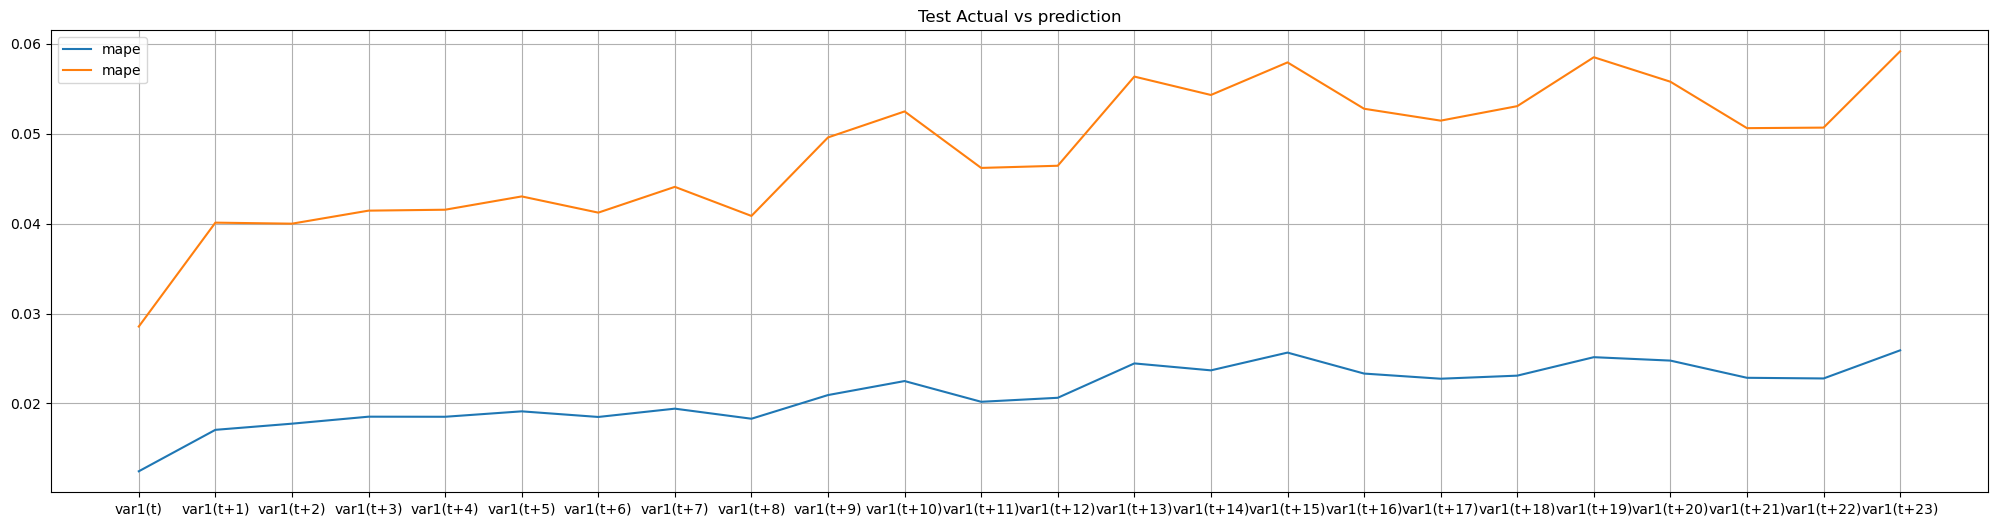

In [57]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot(test_metric_df.index, "test_mae", label='mape', data = test_metric_df)
plt.plot(test_metric_df.index, "test_mape", label='mape', data = test_metric_df)
plt.title("Test Actual vs prediction")
plt.legend()
plt.grid(True)
plt.show()         

# Run 13 - CNN LSTM - 7 days shifted

In [95]:
x_train_2 = train_X.reshape((train_X.shape[0], train_X.shape[2], 1))
x_test_2 = test_X.reshape((test_X.shape[0], test_X.shape[2], 1))
print(x_train_2.shape, train_y.shape, x_test_2.shape, test_y.shape)

(15870, 30, 1) (15870, 1) (3968, 30, 1) (3968, 1)


In [98]:
def get_model_cnn_lstm():
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train_2.shape[1], x_train_2.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=1, activation='relu'))
    model.add(LSTM(160, return_sequences=True, activation='relu'))
    model.add(LSTM(512, return_sequences=False, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError()])
    return model

model13 = get_model_cnn_lstm()
model13.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 6)             12        
                                                                 
 lstm_6 (LSTM)               (None, 30, 160)           106880    
                                                                 
 lstm_7 (LSTM)               (None, 512)               1378304   
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1485709 (5.67 MB)
Trainable params: 1485709 (5.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=training_session_folder + '/run_13/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
]
# fit network
history = model11.fit(x_train_2, train_y, validation_data = (x_test_2, test_y), epochs=500, batch_size=72, callbacks=callbacks_list, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

Epoch 1/500
221/221 - 23s - loss: 0.0841 - mean_absolute_error: 0.0841 - val_loss: 0.1125 - val_mean_absolute_error: 0.1125 - 23s/epoch - 102ms/step
Epoch 2/500
221/221 - 23s - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854 - 23s/epoch - 105ms/step
Epoch 3/500
221/221 - 22s - loss: 0.0460 - mean_absolute_error: 0.0460 - val_loss: 0.0676 - val_mean_absolute_error: 0.0676 - 22s/epoch - 101ms/step
Epoch 4/500
221/221 - 23s - loss: 0.0383 - mean_absolute_error: 0.0383 - val_loss: 0.0713 - val_mean_absolute_error: 0.0713 - 23s/epoch - 104ms/step
Epoch 5/500
221/221 - 23s - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0740 - val_mean_absolute_error: 0.0740 - 23s/epoch - 104ms/step
Epoch 6/500
